Imports/Install -- Required Packages

OBS: All code was written by Luca Cerny Oliveira unless especified as a comment

In [1]:
### Cell to link Notebook to Google Drive

from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
pip install pydicom

     |████████████████████████████████| 2.0 MB 3.2 MB/s 


In [3]:
pip install pypng

     |████████████████████████████████| 48 kB 1.9 MB/s 


In [4]:
# Core imports
import os
import pandas as pd
import numpy as np
import random

# Imports for benchmarking/plotting
import matplotlib.pyplot as plt
import statistics
import time 

# DataLoader
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Deep Learning
import torch
import torch.nn as nn
import torchvision.transforms.functional as F
from torch.optim.lr_scheduler import StepLR, ExponentialLR


# .DIM to .PNG 
import pydicom
import cv2
import PIL
import csv
import png
from skimage import io, transform
from google.colab.patches import cv2_imshow

# **1st Part: Loading and Setting-up data**

Loading data:
*   Images will be Greyscale
*   CT scans are 256x256 Images
*   Patches are 55x55 Images







In [ ]:
#The below function NEEDS to be done separately so it does not have to convert from DICOM everytime
def dcm_path_to_jpg(path,save_path):
  ds = pydicom.read_file(path) # read dicom image
  img = ds.pixel_array # get image array

  ### this normalization expression for dicom to png was taken from
  ### https://pycad.co/how-to-convert-a-dicom-image-into-jpg-or-png/
  img = (np.maximum(img, 0) / img.max()) * 255.0

  img = np.uint8(img)

  cv2.imwrite(save_path,img) # write png image

In [ ]:
dicom_path = '/content/drive/MyDrive/CT_Project/LungCT/'
save_path = '/content/drive/MyDrive/CT_Project/fixedCT/'

for case in sorted(os.listdir(dicom_path)):
  print(case) #make new directory on clean folder
  subpath1 = dicom_path+case+'/'
  save_folder = save_path + case + '/'
  if not(os.path.isdir(save_folder)):
    os.makedirs(save_folder)
  subpath2 = subpath1 + os.listdir(subpath1)[0] + '/' # here is the information for pixel intensity (my guess)
  subpath3 = subpath2 + os.listdir(subpath2)[0] + '/'
  for dcm_img in sorted(os.listdir(subpath3)):
    print(subpath3+dcm_img)
    filename = dcm_img.split('.')[0]
    dcm_file = subpath3 + dcm_img
    save_file = save_folder + filename + '.png'
    dcm_path_to_jpg(dcm_file, save_file)

R_004
/content/drive/MyDrive/CT_Project/LungCT/R_004/06-30-1997-NA-Diagnostic Pre-Surgery Contrast Enhanced CT-71813/3.000000- NONE -29295/1-01.dcm
/content/drive/MyDrive/CT_Project/LungCT/R_004/06-30-1997-NA-Diagnostic Pre-Surgery Contrast Enhanced CT-71813/3.000000- NONE -29295/1-02.dcm
/content/drive/MyDrive/CT_Project/LungCT/R_004/06-30-1997-NA-Diagnostic Pre-Surgery Contrast Enhanced CT-71813/3.000000- NONE -29295/1-03.dcm
/content/drive/MyDrive/CT_Project/LungCT/R_004/06-30-1997-NA-Diagnostic Pre-Surgery Contrast Enhanced CT-71813/3.000000- NONE -29295/1-04.dcm
/content/drive/MyDrive/CT_Project/LungCT/R_004/06-30-1997-NA-Diagnostic Pre-Surgery Contrast Enhanced CT-71813/3.000000- NONE -29295/1-05.dcm
/content/drive/MyDrive/CT_Project/LungCT/R_004/06-30-1997-NA-Diagnostic Pre-Surgery Contrast Enhanced CT-71813/3.000000- NONE -29295/1-06.dcm
/content/drive/MyDrive/CT_Project/LungCT/R_004/06-30-1997-NA-Diagnostic Pre-Surgery Contrast Enhanced CT-71813/3.000000- NONE -29295/1-07.dcm


In [ ]:
### Amount of cases available in dataset + case names:
dataset_folder_path = '/content/drive/MyDrive/CT_Project/fixedCT/'

sorted(os.listdir(dataset_folder_path))

In [ ]:
transform=transforms.Compose([transforms.Grayscale(num_output_channels=1),
                              transforms.Resize(256),
                              transforms.ToTensor()
                              ])

In [5]:
class CT_Scan(Dataset):
    """Lung CT Scan Dataset"""

    def __init__(self, path, cases, transform=None):
        """
        Args:
            path (string): Folder with all images separated by case
            cases (string list): Cases that will be used
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.path = path
        self.cases = cases
        self.transform = transform

        self.path_list = self.count_cases(self.path, self.cases)

    def count_cases(self,path,cases):
        #Parse through cases folders
        path_list = []
        for case in sorted(os.listdir(path)):
          if case in cases:
            for img_path in sorted(os.listdir(path + case + '/')):
              path_list.append(path + case + '/'+img_path)

        return path_list

    def __len__(self):
        return len(self.path_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        #image = np.asarray(self.path_list[idx]).astype(np.uint8)

        image = io.imread(self.path_list[idx])

        noisy = image
        noisy = np.random.poisson(noisy / 255.0 * 30) / 30 * 255  # noisy image

        image = PIL.Image.fromarray(image)

        noisy = PIL.Image.fromarray(noisy)

        if self.transform:
            image = self.transform(image)
            noisy = self.transform(noisy)
        
        top = random.randrange(201)
        left = random.randrange(201)

        image = F.crop(image,top,left,55,55)
        noisy = F.crop(noisy,top,left,55,55)
        if random.random() > 0.5:
          image = F.hflip(image)
          noisy = F.hflip(noisy)
        
        if random.random() > 0.25:
          image = F.vflip(image)
          noisy = F.vflip(noisy)

        sample = {'image': image, 'noisy': noisy}

        return sample

In [ ]:
LungDataset = CT_Scan(path = '/content/drive/MyDrive/CT_Project/fixedCT/', cases = ['R_259'], transform = transform)

torch.Size([1, 55, 55])
tensor([[[0.2471, 0.2157, 0.1765,  ..., 0.4941, 0.5176, 0.5255],
         [0.2510, 0.2078, 0.1686,  ..., 0.5059, 0.5176, 0.5216],
         [0.2510, 0.2078, 0.1608,  ..., 0.5137, 0.5176, 0.5294],
         ...,
         [0.4235, 0.4275, 0.4275,  ..., 0.3961, 0.4000, 0.3922],
         [0.4078, 0.4118, 0.4118,  ..., 0.3922, 0.3922, 0.3961],
         [0.3961, 0.3961, 0.4000,  ..., 0.4039, 0.4039, 0.4118]]])


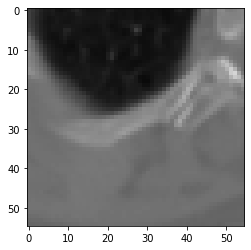

In [ ]:
for idx in range(len(LungDataset)):
  sample_data = LungDataset[idx]
  sample_img, sample_noisy = sample_data['image'], sample_data['noisy']

  if idx == 7:
    print(sample_img.size())
    print(sample_img)
    plt.imshow(sample_img[0],cmap='gray',vmin=0,vmax=1)
    break

torch.Size([1, 55, 55])
tensor([[[0.2000, 0.1843, 0.1882,  ..., 0.4078, 0.4549, 0.5098],
         [0.2392, 0.1843, 0.1843,  ..., 0.5137, 0.4980, 0.5569],
         [0.2627, 0.2235, 0.2000,  ..., 0.4588, 0.4706, 0.5098],
         ...,
         [0.4588, 0.4392, 0.4431,  ..., 0.3922, 0.3608, 0.4118],
         [0.4314, 0.3961, 0.4078,  ..., 0.3294, 0.3765, 0.3804],
         [0.3216, 0.3843, 0.4392,  ..., 0.3804, 0.3843, 0.3922]]])


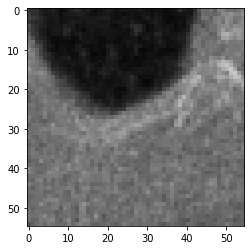

In [ ]:
print(sample_noisy.size())
print(sample_noisy)
plt.imshow(sample_noisy[0],cmap='gray',vmin=0,vmax=1)

In [ ]:
ctloader = DataLoader(LungDataset, batch_size = 50, suffle = True, num_workers=0, drop_last = False)

# **2nd Part: Model, Fit and Evaluation Function Design** 

In [6]:
class DNN(nn.Module):
  def __init__(self):
    super(DNN, self).__init__()
    self.relu = nn.ReLU()

    self.conv1 = nn.Conv2d(1, 64, kernel_size=5)
    self.bn1 = nn.BatchNorm2d(64)
    self.conv2 = nn.Conv2d(64, 128, kernel_size=5)
    self.bn2 = nn.BatchNorm2d(128)
    self.conv3 = nn.Conv2d(128, 256, kernel_size=5)
    self.bn3 = nn.BatchNorm2d(256)
    self.conv4 = nn.Conv2d(256, 512, kernel_size=5)
    self.bn4 = nn.BatchNorm2d(512)
    self.conv5 = nn.Conv2d(512, 1024, kernel_size=5)
    self.bn5 = nn.BatchNorm2d(1024)

    self.deconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=5)
    self.bn6 = nn.BatchNorm2d(512)
    self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=5)
    self.bn7 = nn.BatchNorm2d(256)
    self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=5)
    self.bn8 = nn.BatchNorm2d(128)
    self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=5)
    self.bn9 = nn.BatchNorm2d(64)
    self.deconv5 = nn.ConvTranspose2d(64, 1, kernel_size=5)
  
  def forward(self,x):
    r1 = x
    out = self.conv1(x)
    out = self.relu(out)
    out = self.bn1(out)

    out = self.conv2(out)
    out = self.relu(out)
    out = self.bn2(out)

    r2 = out
    out = self.conv3(out)
    out = self.relu(out)
    out = self.bn3(out)

    out = self.conv4(out)
    out = self.relu(out)
    out = self.bn4(out)

    r3 = out
    out = self.conv5(out)
    out = self.relu(out)
    out = self.bn5(out)


    out = self.deconv1(out)
    out = out + r3
    out = self.relu(out)
    out = self.bn6(out)

    out = self.deconv2(out)
    out = self.relu(out)
    out = self.bn7(out)
    
    out = self.deconv3(out)
    out = out + r2
    out = self.relu(out)
    out = self.bn8(out)

    out = self.deconv4(out)
    out = self.relu(out)
    out = self.bn9(out)

    out = self.deconv5(out)
    out = out + r1
    out = self.relu(out)

    return out


In [7]:
def randomInit(m):
  print("Model Randomly Initialized")
  if isinstance(m, nn.Linear):
    torch.nn.init.xavier_uniform_(m.weight)
    torch.nn.init.zeros_(m.bias)


def fit(model, loss_fn, optimizer, train_loader, batch_size, num_epochs, stat_count = 100,device = None, PATH = '/content/drive/MyDrive/CT_Project/model.pt'):
  if device is not None:
    model.to(device)
  else:
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model.to(device)

  randomInit(model)

  scheduler = ExponentialLR(optimizer, gamma=0.99)

  epoch_loss = []
  train_acc = []

  for epoch in range(num_epochs):
    if epoch != 0:
      mse_eval = []
      scheduler.step()
      epoch_loss.append(loss.item())
      print("End of epoch")
      for train_data in train_loader:
        with torch.no_grad():
          model.eval()
          trainimg, trainnsy = train_data['image'].cuda(), train_data['noisy'].cuda()
          trainoutputs = model(trainnsy)
          mse = loss_fn(trainoutputs, trainimg).item()
          mse_eval.append(mse)
      if statistics.mean(mse_eval) < model_score or epoch == 50:
        print("Score of ", mse, "is the best yet. Saving model ...")
        model_score = mse
        torch.save({'model_state_dict': model.state_dict()}, PATH)
      train_acc.append(mse)
    else:
      model_score = 100000 
    for i, data in enumerate(train_loader, 0):
      with torch.enable_grad():
        model.train()
        images, noisy = data['image'].cuda(), data['noisy'].cuda()
        optimizer.zero_grad()

        outputs = model(noisy)

        loss = loss_fn(outputs, images)

        loss.backward()
        optimizer.step()

        if (i+1) % stat_count == 0:
          print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f'%(epoch+1, num_epochs, i+1, len(train_loader), loss.item()))

  return epoch_loss, train_acc

    
          

def test(model, test_loader, loss_fn,  batch_size = 1, sample_idx = 0, device = None, PATH = '/content/drive/MyDrive/CT_Project/model.pt'):
  checkpoint = torch.load(PATH)
  model.load_state_dict(checkpoint['model_state_dict'])
  if device is not None:
    model.to(device)
  else:
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model.to(device)

  ct = 0
  mse_list = []
  mse_noisy = []
  with torch.no_grad():
    model.eval()
    for test_data in test_loader:
      images, noisy = test_data['image'].cuda(), test_data['noisy'].cuda()

      outputs = model(noisy)

      mse_obj = loss_fn(outputs, images)
      mse = mse_obj.item()
      mse_list.append(mse)

      mse_n_obj = loss_fn(noisy, images)
      mse_n = mse_n_obj.item()
      mse_noisy.append(mse_n)

      if ct == sample_idx:
        denoised = outputs
        LDCT = noisy
        image = images

      ct += 1

  print("Average MSE Loss = ", statistics.mean(mse_list))

  return mse_list, mse_noisy, denoised, LDCT, image

# **3rd Part: Inference**

In [8]:
num_epochs = 60
batch_size = 50


model = DNN()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

In [9]:
transform=transforms.Compose([transforms.Grayscale(num_output_channels=1),
                              transforms.Resize(256),
                              transforms.ToTensor()
                              ])


cases_to_train = ['R_004','R_006','R_013','R_014','R_019','R_020','R_022','R_029','R_033','R_035','R_036','R_043','R_053','R_056','R_061','R_064','R_065','R_066','R_069','R_075','R_077','R_078',
 'R_093','R_098','R_102','R_108','R_111','R_116','R_117','R_124','R_126','R_127','R_137','R_141','R_143','R_146','R_150','R_157','R_168','R_170','R_172','R_175','R_180','R_185','R_191','R_193',
 'R_208','R_209','R_210','R_214','R_232','R_233','R_237','R_239','R_256','R_266','R_267','R_273','R_274']

cases_to_test = ['R_144', 'R_259']

for case in cases_to_test:
  if case in cases_to_train:
    print(case)
    print("!!!DO NOT PROCEED!!!")
    print("Scans from the hold-out test set leaked into the train set. Reselect cases")

LungDataset = CT_Scan(path = '/content/drive/MyDrive/CT_Project/fixedCT/', cases = cases_to_train, transform = transform)

TestCase = CT_Scan(path = '/content/drive/MyDrive/CT_Project/fixedCT/', cases = cases_to_test, transform = transform)

train_loader = DataLoader(LungDataset, batch_size = batch_size, shuffle = True, drop_last = True)

test_loader = DataLoader(TestCase, batch_size = 1, shuffle = False, drop_last = True)

In [10]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

DNN(
  (relu): ReLU()
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(5, 5), stride=(1, 1))
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(512, 1024, kernel_size=(5, 5), stride=(1, 1))
  (bn5): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv1): ConvTranspose2d(1024, 512, kernel_size=(5, 5), stride=(1, 1))
  (bn6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv2): ConvTranspose2d(512, 256, kernel_size=

In [14]:
start = time.time()

epoch_loss, train_acc = fit(model, loss_fn, optimizer, train_loader, batch_size, num_epochs, stat_count = 5,device = None, PATH = '/content/drive/MyDrive/CT_Project/model_patched_var_ker.pt')

end = time.time()

Model Randomly Initialized
Epoch [1/60], Step [5/90], Loss: 11.2450
Epoch [1/60], Step [10/90], Loss: 1.9684
Epoch [1/60], Step [15/90], Loss: 0.9079
Epoch [1/60], Step [20/90], Loss: 0.4481
Epoch [1/60], Step [25/90], Loss: 0.2580
Epoch [1/60], Step [30/90], Loss: 0.2545
Epoch [1/60], Step [35/90], Loss: 0.1954
Epoch [1/60], Step [40/90], Loss: 0.1413
Epoch [1/60], Step [45/90], Loss: 0.1127
Epoch [1/60], Step [50/90], Loss: 0.1014
Epoch [1/60], Step [55/90], Loss: 0.0901
Epoch [1/60], Step [60/90], Loss: 0.0744
Epoch [1/60], Step [65/90], Loss: 0.0751
Epoch [1/60], Step [70/90], Loss: 0.0800
Epoch [1/60], Step [75/90], Loss: 0.0707
Epoch [1/60], Step [80/90], Loss: 0.0649
Epoch [1/60], Step [85/90], Loss: 0.0623
Epoch [1/60], Step [90/90], Loss: 0.0617
End of epoch
Score of  0.060634009540081024 is the best yet. Saving model ...
Epoch [2/60], Step [5/90], Loss: 0.0745
Epoch [2/60], Step [10/90], Loss: 0.0519
Epoch [2/60], Step [15/90], Loss: 0.0491
Epoch [2/60], Step [20/90], Loss: 0

In [15]:
hours_elapsed = ((end-start)/3600)
print("Model Training took ", hours_elapsed, "hours")

Model Training took  5.912714628444777 hours


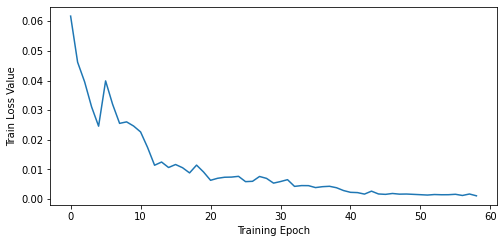

In [16]:
plt.figure(figsize=(8,8))
plt.subplot(212)
plt.plot(range(len(epoch_loss)), epoch_loss)
plt.xlabel('Training Epoch')
plt.ylabel('Train Loss Value')
plt.savefig('/content/drive/MyDrive/CT_Project/trainloss_patched_var.png')
plt.show()

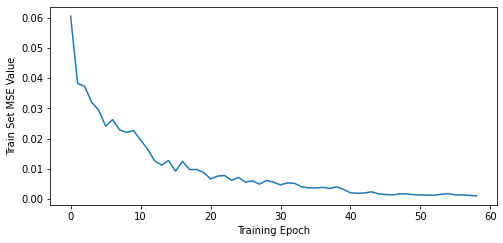

In [17]:
plt.figure(figsize=(8,8))
plt.subplot(212)
plt.plot(range(len(train_acc)), train_acc)
plt.xlabel('Training Epoch')
plt.ylabel('Train Set MSE Value')
plt.savefig('/content/drive/MyDrive/CT_Project/trainacc_patched_var.png')
plt.show()

# **4th Part: Testing**

model_patched = 55x55 patches with Transforms

model_patched2 = 55x55 patches with Transforms

model_patched_var_ker = 55x55 patches with Transforms, Exponential LR, 60 epochs and no Model Checkpoint (forced save at epoch 50)

In [11]:
error, noisy_error, denoised, LDCT, image = test(model, test_loader, loss_fn,  batch_size = 1, device = None, sample_idx = 7, PATH = '/content/drive/MyDrive/CT_Project/model_patched_var_ker.pt')

Average MSE Loss =  0.0011397965223681095


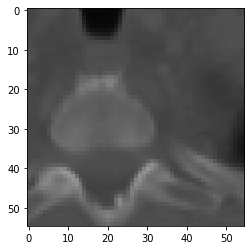

In [12]:
plt.imshow(image.cpu()[0][0],cmap='gray',vmin=0,vmax=1)

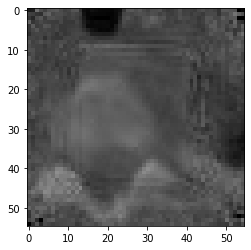

In [13]:
plt.imshow(denoised.cpu()[0][0],cmap='gray',vmin=0,vmax=1)

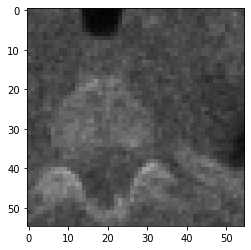

In [14]:
plt.imshow(LDCT.cpu()[0][0],cmap='gray',vmin=0,vmax=1)

In [15]:
print("There were ",len(error), "Low-dose CT (LDCT) scans analyzed in the hold-out test set:")
print("\n")
print("\n")
print("The mean MSE for the LDCT scans was ", statistics.mean(noisy_error), "+-", statistics.stdev(noisy_error))
print("The highest MSE error for  LDCT scans was ",max(noisy_error), "and the minimum was", min(noisy_error))
print("\n")
print("The mean MSE for the Denoised LDCT scans was ", statistics.mean(error), "+-", statistics.stdev(error))
print("The highest MSE error for Denoised LDCT scans was ",max(error), "and the minimum was", min(error))

There were  151 Low-dose CT (LDCT) scans analyzed in the hold-out test set:




The mean MSE for the LDCT scans was  0.0008997760696910223 +- 0.00044225782439344385
The highest MSE error for  LDCT scans was  0.0016963450470939279 and the minimum was 2.7737585696741007e-05


The mean MSE for the Denoised LDCT scans was  0.0011397965223681095 +- 0.0003601885857866769
The highest MSE error for Denoised LDCT scans was  0.001889029867015779 and the minimum was 0.0001100422814488411


In [22]:
error, noisy_error, denoised, LDCT, image = test(model, test_loader, loss_fn,  batch_size = 1, device = None, sample_idx = 7, PATH = '/content/drive/MyDrive/CT_Project/model_patched.pt')

Average MSE Loss =  0.001203673659470734


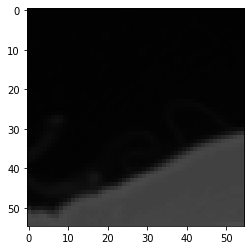

In [23]:
plt.imshow(image.cpu()[0][0],cmap='gray',vmin=0,vmax=1)

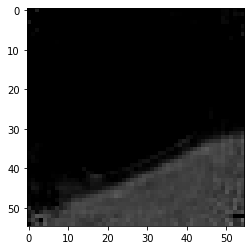

In [24]:
plt.imshow(denoised.cpu()[0][0],cmap='gray',vmin=0,vmax=1)

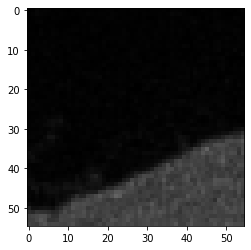

In [25]:
plt.imshow(LDCT.cpu()[0][0],cmap='gray',vmin=0,vmax=1)

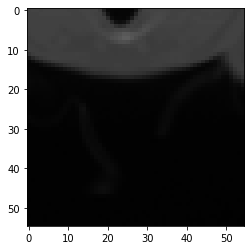

In [19]:
plt.imshow(image.cpu()[0][0],cmap='gray',vmin=0,vmax=1)

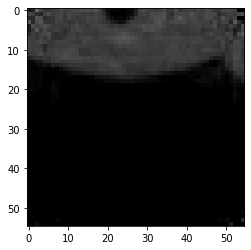

In [20]:
plt.imshow(denoised.cpu()[0][0],cmap='gray',vmin=0,vmax=1)

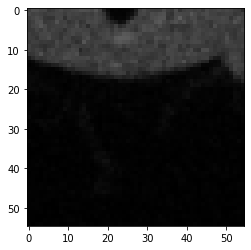

In [21]:
plt.imshow(LDCT.cpu()[0][0],cmap='gray',vmin=0,vmax=1)

In [ ]:
error, noisy_error, denoised, LDCT, image = test(model, test_loader, loss_fn,  batch_size = 1, device = None, sample_idx = 7, PATH = '/content/drive/MyDrive/CT_Project/model_patched2.pt')

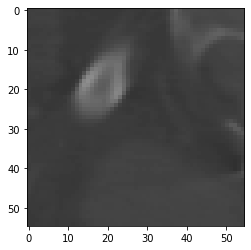

In [ ]:
plt.imshow(image.cpu()[0][0],cmap='gray',vmin=0,vmax=1)

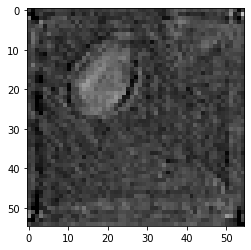

In [ ]:
plt.imshow(denoised.cpu()[0][0],cmap='gray',vmin=0,vmax=1)

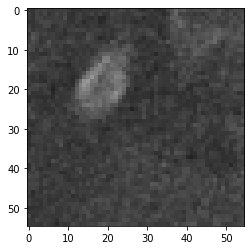

In [ ]:
plt.imshow(LDCT.cpu()[0][0],cmap='gray',vmin=0,vmax=1)

In [ ]:
print(denoised.cpu()[0][0])